In [3]:
import stokespy
from stokespy.instload import load_HinodeSP_stokes, load_HinodeSP_magvec, load_HMI_stokes, load_HMI_magvec 
from stokespy import StokesParamCube, StokesParamMap, StokesProfile
import datetime
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, SpectralCoord

from sunpy.image import coalignment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

# Setup the autoreload function.
%load_ext autoreload
%autoreload 2

In [2]:
def get_image_shift(image1, image2):
    # slightly modified code snippet from bitbucket to determine the shift
    # between two images using FFT:
    
    # discrete fast fourier transformation and complex conjugation of image2 
    image1FFT = np.fft.fft2(image1)
    image2FFT = np.conjugate( np.fft.fft2(image2) )

    # inverse fourier transformation of product -> equal to cross correlation
    imageCCor = np.real( np.fft.ifft2( (image1FFT*image2FFT) ) )

    # shift the zero-frequency component to the center of the spectrum
    imageCCorShift = np.fft.fftshift(imageCCor)

    # determine the distance of the maximum from the center
    row, col = image1.shape

    yshift, xshift = np.unravel_index( np.argmax(imageCCorShift), (row,col) )

    xshift -= int(col/2)
    yshift -= int(row/2)

    return xshift, yshift

# Load SDO/HMI data series

In [4]:
# Select a date and time to search for observations.
# Currently the input needs to be an astropy.time.Time object.
# We plant to make it so that the input can be any valid input to
# transform into a astropy.time.Time object.

#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')  # Original
#user_date = astropy.time.Time(datetime.datetime(2017, 8, 22, 17, 11, 4), scale='tai')  # AR near limb
user_date = astropy.time.Time(datetime.datetime(2017, 9, 5, 3, 4, 4), scale='tai')  # AR near disc center
user_dir = os.getcwd() + '/Data/SDO/'

# Each function loads the lvl1 and inversion HMI data 
# (derotated but not scaled if needed).
lvl1_c_HMI = load_HMI_stokes(user_date, user_dir, user_notify='gdima@hawaii.edu', 
                 download=False, show_files=False, derotate=True)
print(' ~~~~~~ ')
lvl2_c_HMI = load_HMI_magvec(user_date, user_dir, user_notify='gdima@hawaii.edu', 
                 download=False, show_files=False, derotate=True)

Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User data directory: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested. Found 24 Stokes files with unique timestamp(s):
['20170905_030000_TAI']
OBS: Derotating each image
Created Stokes data cube with dimensions: (4, 6, 4098, 4098)
 ~~~~~~ 
Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User data directory: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested. Found 25 inversion files with timestamps: 
['20170905_030000_TAI']
OBS: Derotating each magnetic field image.
Created magnetic field data cube with dimensions: (3, 4098, 4098)


In [5]:
# Information from the WCS attached to the cubes.
# Note the index ordering is different between the data array and the header information.
# 
lvl1_c_HMI.wcs,lvl2_c_HMI.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.0  0.0  6.173345e-07  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  3.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  7.4040177438477e-22  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 7.4040177438477e-22  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  6.88e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.0  0.0  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
 PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  1.0  
 NAXIS : 0  0)

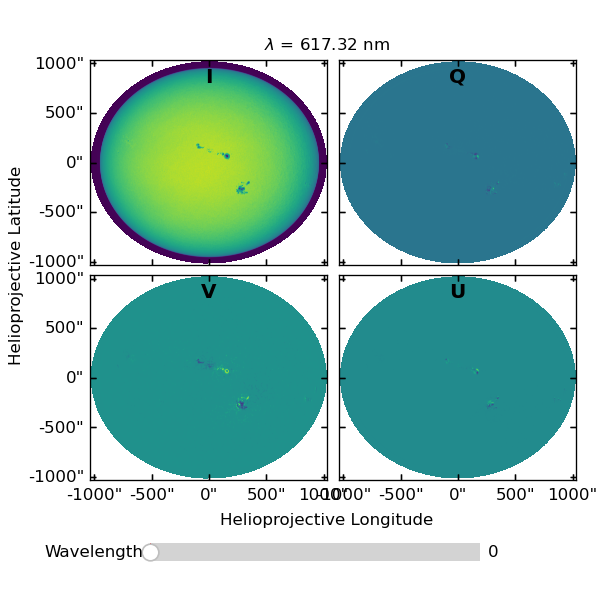

In [41]:
# First we can see how the data looks at all wavelengths.
%matplotlib widget

lvl1_c_HMI.plot()

# Load Hinode/SP data series

In [6]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')
#user_date = '20201101_200602'  # Quiet Sun
#user_date = '20170822_171104'   # AR near limb
user_date = '20170905_030404'  # AR near disc center

# Assume that all the files in the indicated directory are part of the scan. 
# TODO: Validate the scan files using the header information.

user_dir = os.getcwd() + '/Data/Hinode/Level1/' + user_date
lvl1_c_SP = load_HinodeSP_stokes(user_date, user_dir)

magnetic_params=['Field_Strength', 
                 'Field_Inclination', 
                 'Field_Azimuth',
                 'Stray_Light_Fill_Factor']
user_dir = os.getcwd() + '/Data/Hinode/Level2/'
lvl2_c_SP = load_HinodeSP_magvec(user_date, user_dir, magnetic_params=magnetic_params)


Created Stokes data cube with dimensions: (4, 112, 512, 485)
Created magnetic field data cube with dimensions: (4, 512, 485)


In [5]:
# Information from the WCS attached to the cube.
# Note the index ordering is different between the data array and the header information.

lvl1_c_SP.wcs, lvl2_c_SP.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083262125651  0.01127722226928711  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0)

In [6]:
print(lvl1_c_SP.spectral_axis.to(u.nm)[0:20])

[630.08840305 630.09055795 630.09271285 630.09486775 630.09702265
 630.09917755 630.10133245 630.10348735 630.10564225 630.10779715
 630.10995205 630.11210695 630.11426185 630.11641675 630.11857165
 630.12072655 630.12288145 630.12503635 630.12719125 630.12934615] nm


In [7]:
print('Units for each axis: ', lvl1_c_SP.wcs.world_axis_units)

Units for each axis:  ['deg', 'deg', 'm', '']


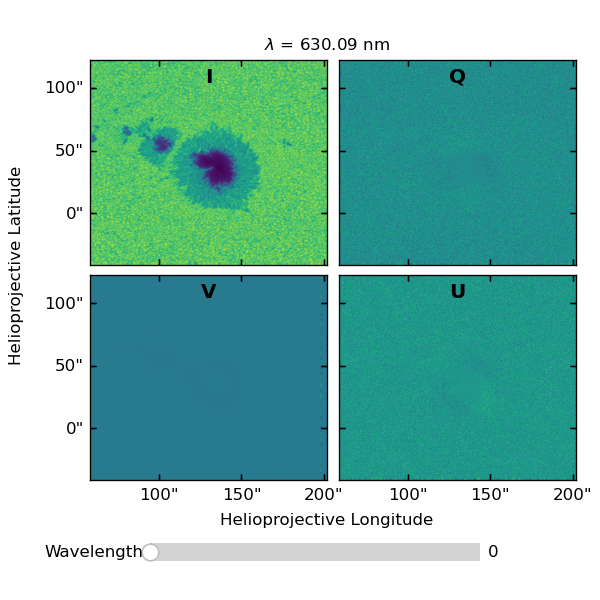

In [43]:
# Quick look at the data.

lvl1_c_SP.plot()

In [12]:
# The wcs contructor converts inputs into 'deg' and 'm'.
# This number is comparable to the values using
print('Spatial sampling along X (arcsec): ', \
      lvl1_wcs.wcs.cdelt[0]*u.deg.to(u.arcsec), 151/512)

print('Spatial sampling along Y (arcsec): ', \
      lvl1_wcs.wcs.cdelt[1]*u.deg.to(u.arcsec), 162/511)

print('Level1 FOV center coordinates (x,y)[arcsec] = :',\
      lvl1_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl1_wcs.wcs.crval[1]*u.deg.to(u.arcsec))

print('Level2 FOV center coordinates (x,y)[arcsec] = :',\
      lvl2_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl2_wcs.wcs.crval[1]*u.deg.to(u.arcsec))


Spatial sampling along X (arcsec):  0.29714 0.294921875
Spatial sampling along Y (arcsec):  0.319978 0.31702544031311153
Level1 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598
Level2 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598


WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
CRPIX : 243.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
NAXIS : 0  0

In [14]:
lvl1_c_SP.frame

<Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (58.05512713, -41.15637222)>

In [30]:
head1['XSCALE'],head2['XSCALE'],head1['YSCALE'], head2['YSCALE']

(0.297140002251, 0.29714, 0.319979995489, 0.319978)

In [25]:
(512+1)/2

256.5

In [22]:
lvl1_c_SP.data.shape

(4, 112, 512, 485)

In [26]:
lvl1_c_SP.wcs.wcs.cdelt

array([8.25388889e-05, 8.88827778e-05, 2.15490000e-12, 1.00000000e+00])

In [13]:
print(head1['XCEN'], head2['XCEN'], head1['YCEN'],head2['YCEN'])

55.8102 96.301 40.8188 40.5247


In [14]:
print(head1['XSCALE'], head2['XSCALE'], head1['YSCALE'],head2['YSCALE'])

0.297140002251 0.29714 0.319979995489 0.319978


In [15]:
print(head1['NAXIS1'], head2['NAXIS1'], head1['NAXIS2'], head2['NAXIS2'])

112 485 512 512


In [18]:
lv1_wcs.wcs.crpix

array([243. , 256.5,  56.5,   0. ])

In [57]:
# Look at the centeral position for each header.
nslit = len(head_all)
xcen_a = np.zeros(nslit)
ycen_a = np.zeros(nslit)

for i in range(nslit):
    xcen_a[i] = head_all[i]['XCEN']
    ycen_a[i] = head_all[i]['YCEN']

129.963 40.598


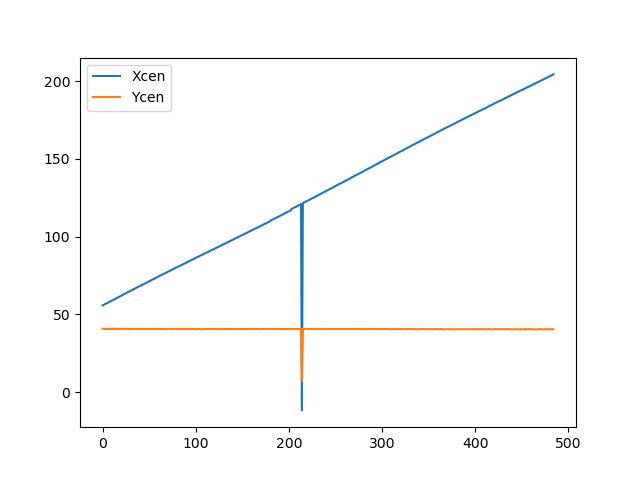

In [33]:
%matplotlib widget

plt.plot(xcen_a, label='Xcen')
plt.plot(ycen_a, label='Ycen')
print(np.median(xcen_a), np.median(ycen_a))
plt.legend()

In [36]:
import os
user_dir = os.getcwd() + '/Data/Hinode/'
level2_fname = user_dir + '/Level2/' + user_date + '.fits'
SP_level2 = astropy.io.fits.open(level2_fname)

In [43]:
x_loc = SP_level2[38].data
x_loc

array([[ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ],
       [ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ],
       [ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ],
       ...,
       [ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ],
       [ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ],
       [ 55.8102,  56.0389,  56.4234, ..., 203.626 , 203.914 , 204.278 ]],
      dtype=float32)

In [48]:
np.median(x_loc[0,:])

129.963

In [42]:
y_loc = SP_level2[39].data
y_loc

array([[-41.096077, -41.09678 , -41.174778, ..., -41.43118 , -41.35458 ,
        -41.43248 ],
       [-40.7761  , -40.776802, -40.8548  , ..., -41.111202, -41.034603,
        -41.112503],
       [-40.456116, -40.456818, -40.534817, ..., -40.791218, -40.71462 ,
        -40.79252 ],
       ...,
       [121.77374 , 121.77304 , 121.69504 , ..., 121.438644, 121.51524 ,
        121.43734 ],
       [122.09372 , 122.09302 , 122.015015, ..., 121.75862 , 121.83522 ,
        121.75732 ],
       [122.413704, 122.413   , 122.33501 , ..., 122.0786  , 122.1552  ,
        122.0773  ]], dtype=float32)

In [93]:
# Computer the centers of each slit.
Ny, Nx = y_loc.shape
y_cen = np.zeros(Nx)
x_cen = np.zeros(Nx)
for i in range(Nx):
    y_cen[i] = np.median(y_loc[:,i]) + head2['YSCALE']/2
    x_cen[i] = x_loc[0,i]

In [94]:
np.median(y_loc) - np.median(y_cen)

-0.24607908789062805

In [95]:
y_cen[0:10]-ycen_a[0:10],x_cen[0:10]-xcen_a[0:10]

(array([ 2.47656250e-06,  5.72265627e-07, -2.35742187e-06,  1.52441407e-06,
        -3.79882806e-07, -2.28417969e-06, -4.18847656e-06, -4.24951172e-06,
         1.47558594e-06, -3.08984374e-06]),
 array([-2.62451174e-07, -1.53198242e-06,  8.78906249e-07,  1.17797852e-06,
        -7.01904298e-07, -8.78906249e-07, -3.72314453e-07,  1.01928711e-06,
         1.04980469e-06, -1.43432617e-06]))

In [92]:
np.median(y_cen) + head2['YSCALE']/2

40.5980001694336

In [47]:
lvl2_c_SP.wcs.wcs.crval*[3600,3600,1]

array([129.963,  40.598,   0.   ])

In [77]:
lvl2_c_SP.wcs.wcs.cdelt*3600/2

array([1.48570e-01, 1.59989e-01, 1.80000e+03])

129.963 40.598


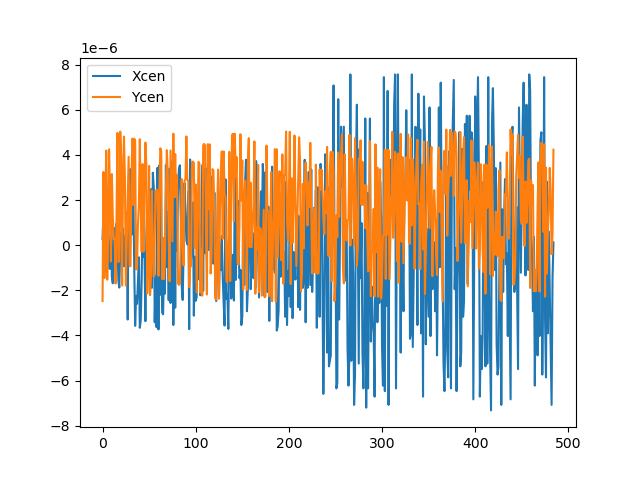

In [79]:
%matplotlib widget

plt.plot(xcen_a-x_cen, label='Xcen')
plt.plot(ycen_a-y_cen - head2['YSCALE']/2, label='Ycen')
#plt.plot(x_cen, label='Xcen(lvl2)')
#plt.plot(y_cen, label='Ycen(lvl2)')

print(np.median(xcen_a), np.median(ycen_a))
plt.legend()

# Co-align Hinode and HMI observations

One application of the stokespy package involves comparing measurements from the same region,
perhaps indicated by a set of world coordinates. However, because the WCS attached to each datacube 
is only as good as the information in the data headers. 

Thanks to good temporal coverage from HMI we can always find co-temporal observations from HMI and Hinode/SP. We first look at the alignment between features in the two images naively assuming the WCS information is correct. We notice large differences between the coordinates assigned to the same AR feature on the sun. 

Using a cross-correlation technique we can find the misalignment due to translation between the two data sets. 
This particular example does not account for misalignment involving rotations but a more involved version of this example could be created to account for rotations as well. However, it would involve resampling of the data. 

## Load images to compare

In [7]:
### Hinode map ###
# We can select the wavelength near 603.19 nm for the continuum
wav_SP = 630.19 * u.nm

# Here we use StokesParamMap which is custom class similar to StokesCube for 2D data slices.
# Convenience methods with polymorphic inputs are provided for the StokesCube object to select
# an image slice based on a Units object. 
SP_map = lvl1_c_SP.I_map(wav_SP)
print(type(SP_map))
print(SP_map)

ix_0, wav0 =  47 6.3018968335e-07 m
<class 'stokespy.stokespy.StokesParamMap'>
NDCube
------
Dimensions: [512. 485.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64


In [8]:
### HMI map ###

# We can also pass integers to the method.
HMI_map = lvl1_c_HMI.I_map(0)
print(type(HMI_map))
print(HMI_map)

ix_0, wav0 =  0 6.173173e-07 m
<class 'stokespy.stokespy.StokesParamMap'>
NDCube
------
Dimensions: [4098. 4098.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float32


## Compare the two images.

In [9]:
# The HMI FOV is much larger than the Hinode/SP FOV. 
# We will crop to the approximate coordinates that Hinode/SP is observing.
# The physical world coordinates can be built into 
# Skycoordinates and use the NDCube crop functionality on the HMI data.

# We arbitrarily choose to call the first and second axis following the order of the
# array data shape: [stokes, wavelength, y, x] so ax1, ax2= y, x in physical coordinates.
# This is the same convention adopted for the coord1_axis and coord2_axis attributes.

# Units for the axis.
#ax2_u = lvl1_c_SP.wcs.world_axis_units[0] 
#ax1_u = lvl1_c_SP.wcs.world_axis_units[1] 

xmin_SP, xmax_SP = lvl1_c_SP.coord2_axis(0)[0].Tx, lvl1_c_SP.coord2_axis(0)[-1].Tx
ymin_SP, ymax_SP = lvl1_c_SP.coord1_axis(0)[0].Ty, lvl1_c_SP.coord1_axis(0)[-1].Ty

bottom_left_skyc = SkyCoord(Tx = xmin_SP, Ty = ymin_SP, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc = SkyCoord(Tx = xmax_SP, Ty = ymax_SP, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop = HMI_map.crop((bottom_left_skyc), (top_right_skyc))
print(HMI_map_crop.data.shape)

(325, 286)


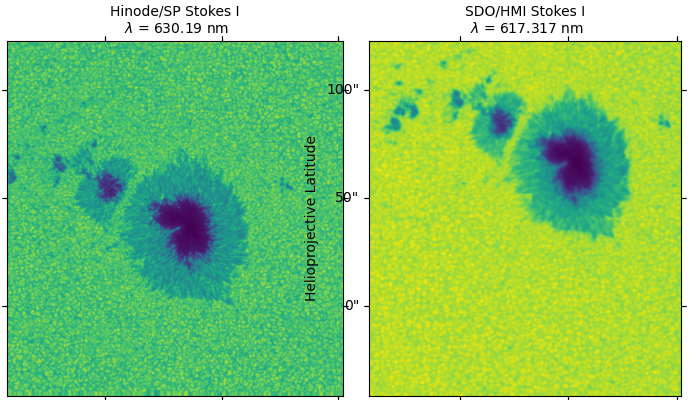

In [10]:
# Compare the resulting images
# Visually we can see that there is an offset between the WCS constructed for the two 
# datasets.

%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,4), dpi=100)

ax1 = fig.add_subplot(121, projection=SP_map.wcs)
ax2 = fig.add_subplot(122, projection=HMI_map_crop.wcs)

# Here we use the custom stokespy plotting functionality.
SP_map.plot(ax=ax1)
HMI_map_crop.plot(ax=ax2)

## Perform a cross-correlation to get the translation offsets between the two images.

In [11]:
# To determine the offset between the Hinode and HMI images we need to run a cross-correration
# To do this we need to crop the HMI image to include the Hinode area together with a border.

pad = 30*u.arcsec

bottom_left_skyc_pad = SkyCoord(Tx = xmin_SP-pad, Ty = ymin_SP-pad, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_pad = SkyCoord(Tx = xmax_SP+pad, Ty = ymax_SP+pad, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_pad = HMI_map.crop((bottom_left_skyc_pad), (top_right_skyc_pad))
print(HMI_map_crop_pad.data.shape)


(444, 406)


### Change Hinode map resolution to match HMI

In [12]:
# The Hinode/SP map has a different spatial resolution so we first match resolutions
# by degrading the higher resolution Hinode data to roughy match HMI resolution.

SP_img0 = ndimage.gaussian_filter(SP_map.data,1.3)
SP_img = ndimage.zoom(SP_img0, [HMI_map_crop.data.shape[0]/SP_img0.shape[0], 
                                HMI_map_crop.data.shape[1]/SP_img0.shape[1]])

print('Zoom values: ', HMI_map_crop.data.shape[0]/SP_img0.shape[0],
                         HMI_map_crop.data.shape[1]/SP_img0.shape[1])

print('Original image shape: ', SP_img0.shape)
print('Degraded resolution image shape: ', SP_img.shape)
print('HMI cutout image shape: ', HMI_map_crop.data.shape)

Zoom values:  0.634765625 0.5896907216494846
Original image shape:  (512, 485)
Degraded resolution image shape:  (325, 286)
HMI cutout image shape:  (325, 286)


Text(0, 0.5, 'Pixel')

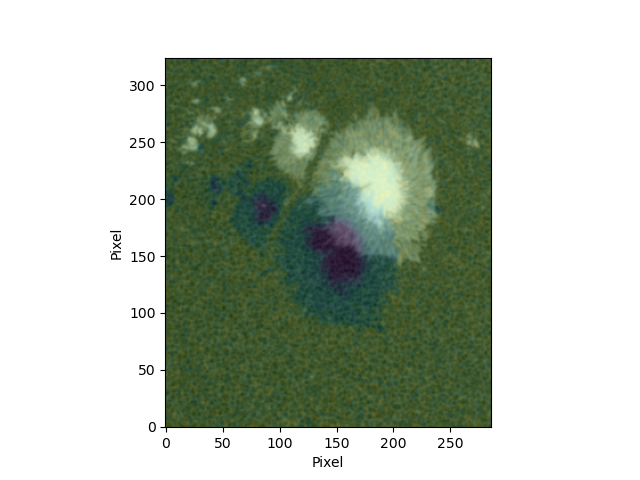

In [13]:
# We can overplot the HMI and resized Hinode map.
# This makes it easier to see the offset images.
%matplotlib widget

ax1 = plt.subplot(111)

ax1.imshow(SP_img, origin='lower')
ax1.imshow(HMI_map_crop.data, origin='lower', cmap='Greys', alpha=0.7)

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

### Calculate the alignment offset

In [14]:
# The co-alignment is calculated between the padded cropped HMI image and the resampled
# Hinode map. The padding around the HMI cropped area also needs to be removed to calculate
# the final shift.
xyshift = coalignment.calculate_shift(HMI_map_crop_pad.data, SP_img)

# We can use the pixel plate scale from each instrument to calculate the offsets between the
# images in world coordinates and pixel units. 
HMI_cdelt = lvl1_c_HMI.wcs.wcs.cdelt[0:2] * u.Quantity(1, lvl1_c_HMI.wcs.world_axis_units[0])/u.pix
SP_cdelt = lvl1_c_SP.wcs.wcs.cdelt[0:2] * u.Quantity(1, lvl1_c_SP.wcs.world_axis_units[0])/u.pix

# Calculate the shifts needed in real world coordinates.
xyshift_real = []
xyshift_real.append(xyshift[0] * HMI_cdelt[0] - pad)
xyshift_real.append(xyshift[1] * HMI_cdelt[1] - pad)

print('HMI (x,y) pixel sampling       = ', HMI_cdelt.to(u.arcsec/u.pix))
print('Hinode/SP (x,y) pixel sampling = ', SP_cdelt.to(u.arcsec/u.pix))


print('Offset along the x direction = ', np.round(xyshift_real[1].to(u.arcsec),1), ' = ', \
                                      np.round(xyshift_real[1]/HMI_cdelt[1],1), '[HMI] =', \
                                      np.round(xyshift_real[1]/SP_cdelt[1],1), '[SP]')
print('Offset along the y direction = ', np.round(xyshift_real[0].to(u.arcsec),1), ' = ',\
                                      np.round(xyshift_real[0]/HMI_cdelt[0]), '[HMI] =',
                                      np.round(xyshift_real[0]/SP_cdelt[0],1), '[SP]')

HMI (x,y) pixel sampling       =  [0.50434315 0.50434315] arcsec / pix
Hinode/SP (x,y) pixel sampling =  [0.29714 0.31998] arcsec / pix
Offset along the x direction =  17.6 arcsec  =  34.9 pix [HMI] = 55.0 pix [SP]
Offset along the y direction =  30.0 arcsec  =  60.0 pix [HMI] = 101.0 pix [SP]


In [20]:
xyshift_real

[<Quantity 0.00833801 deg>, <Quantity 0.00489238 deg>]

### Recrop the HMI data to see if the alignment is improved.

In [15]:
# Recrop the data accounting for the shift.

bottom_left_skyc_1 = SkyCoord(Tx = xmin_SP+xyshift_real[1], Ty = ymin_SP+xyshift_real[0], frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_1 = SkyCoord(Tx = xmax_SP+xyshift_real[1], Ty = ymax_SP+xyshift_real[0], frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_1 = HMI_map.crop((bottom_left_skyc_1), (top_right_skyc_1))
print(HMI_map_crop_1.data.shape)

(325, 286)


Text(0, 0.5, 'Pixel')

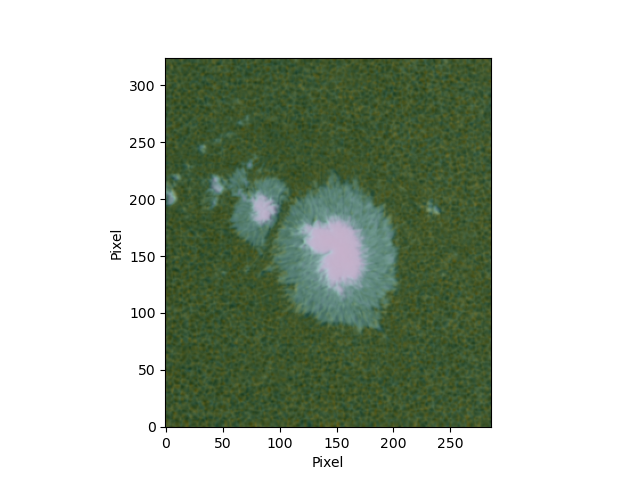

In [16]:
# We can overplot the HMI and resized Hinode map after the shift correction.
# This makes it easier to see the offset images.
%matplotlib widget

ax1 = plt.subplot(111)

ax1.imshow(SP_img, origin='lower')
ax1.imshow(HMI_map_crop_1.data, origin='lower', cmap='Greys', alpha=0.7)

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

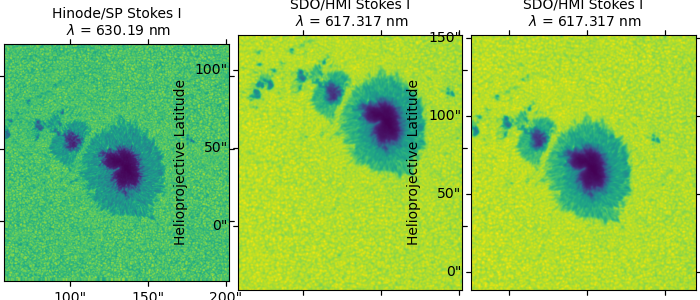

In [17]:
# Comparing the data arrays using the WCS units we see that there is still a mismatch between
# the physical coordinates for the two regions. 
# This can be fixed by correcting the WCS attached to one of the StokesCube objects.

%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,3), dpi=100)

ax1 = fig.add_subplot(131, projection=SP_map.wcs)
ax2 = fig.add_subplot(132, projection=HMI_map_crop.wcs)
ax3 = fig.add_subplot(133, projection=HMI_map_crop_1.wcs)

# Here we use the custom stokespy plotting functionality.
SP_map.plot(ax=ax1)
HMI_map_crop.plot(ax=ax2)
HMI_map_crop_1.plot(ax=ax3)

## Change the Hinode/SP WCS to correct for the offset

There are two ways to perform a translation of the WCS: 

1. Modify the crval values that save the center location in the real world system (e.g. Helioprojective)
To implement this we convert the offsets from HMI pixels to offsets in real world coordinates.

2. Modify the crpix value that save the center location in pixel units.
The Hinode/SP plate scale is different from SDO/HMI and the cross-correlation is computed in HMI pixels.
To implement this we have to perform an extra step of converting from real world coordinates into SP pixels.

Here we demonstrate the first solution.

In [19]:
# We can either update the WCS of the orginal StokesCube
# of construct a new object with the updated WCS.

target_wcs = lvl1_c_SP.wcs.deepcopy()
target_wcs.wcs.crval[0] += xyshift_real[1].value
target_wcs.wcs.crval[1] += xyshift_real[0].value

lvl1_c_SP_1 = stokespy.StokesCube(lvl1_c_SP.data, target_wcs)
lvl2_c_SP_1 = stokespy.MagVectorCube(lvl2_c_SP.data, target_wcs, magnetic_params=lvl2_c_SP.magnetic_axis)

lvl1_c_SP.wcs, lvl1_c_SP_1.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.04099321286583741  0.019615231970415658  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888951416667e-05  8.888333208027778e-05  2.1549e-12  1.0  
 NAXIS : 0  0)

In [20]:
# Define a new image from the updated cube.
SP_map_1 = lvl1_c_SP_1.I_map(wav_SP)

ix_0, wav0 =  47 6.3018968335e-07 m


In [28]:
# Recrop the HMI data to the updated Hinode image coordinates.

xmin_SP_1, xmax_SP_1 = lvl1_c_SP_1.coord2_axis(0)[0].Tx, lvl1_c_SP_1.coord2_axis(0)[-1].Tx
ymin_SP_1, ymax_SP_1 = lvl1_c_SP_1.coord1_axis(0)[0].Ty, lvl1_c_SP_1.coord1_axis(0)[-1].Ty

bottom_left_skyc_1 = SkyCoord(Tx = xmin_SP_1, Ty = ymin_SP_1, frame = lvl1_c_HMI.meta['frame'])
top_right_skyc_1 = SkyCoord(Tx = xmax_SP_1, Ty = ymax_SP_1, frame = lvl1_c_HMI.meta['frame'])

HMI_map_crop_1 = HMI_map.crop((bottom_left_skyc_1), (top_right_skyc_1))
print(HMI_map_crop_1.data.shape)

(4, 6, 325, 286)


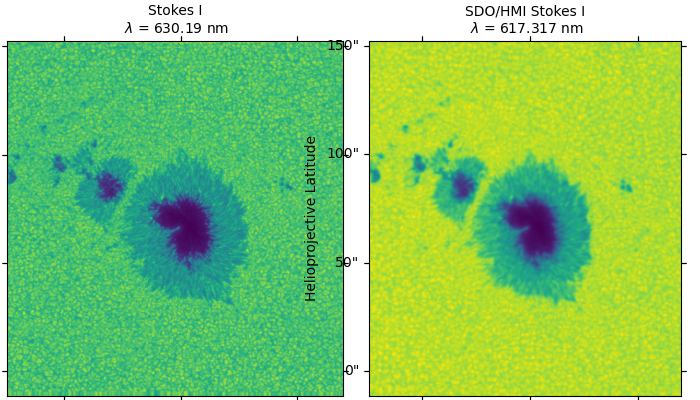

In [27]:
# Compare the results of the alignment.

%matplotlib widget

fig = plt.figure(constrained_layout=True, figsize=(7,4), dpi=100)

ax1 = fig.add_subplot(121, projection=SP_map_1.wcs)
ax2 = fig.add_subplot(122, projection=HMI_map_crop_1.wcs)

# Here we use the custom stokespy plotting functionality.
SP_map_1.plot(ax=ax1)
HMI_map_crop_1.plot(ax=ax2)

## Look at spectra from both maps

In [23]:
# Choose a point in the image to display

test_skycoord1 = SkyCoord(Tx = 148 * u.arcsec, Ty = 67 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])

243 244


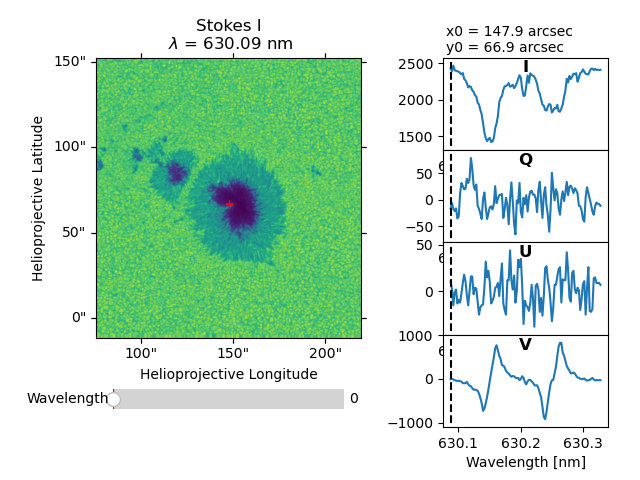

In [24]:
%matplotlib widget

lvl1_c_SP_1.plot(coords=test_skycoord1, context=0)

In [29]:
# To make it easier to visualize we can crop the larger HMI StokesCube to the
# Hinode FOV.
HMI_cube_crop_1 = lvl1_c_HMI.crop((bottom_left_skyc_1, None, None), (top_right_skyc_1, None, None))
print(HMI_cube_crop_1.data.shape)

(4, 6, 325, 286)


143 155


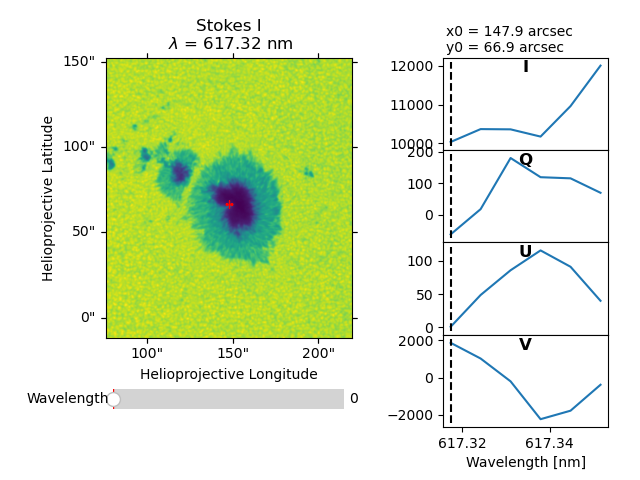

In [30]:
%matplotlib widget

HMI_cube_crop_1.plot(coords=test_skycoord1, context=0)